# Install/Import packages

In [1]:
# These installations and upgrading are done in order to be able to get data from yahoo finance
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 7.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
from datetime import date
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from tqdm import tqdm # to get progress bar
from IPython.display import clear_output
import lightgbm as lbgm
from xgboost import XGBClassifier
from tensorflow import keras
import tensorflow as tf
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from re import compile as re_compile
from sklearn.preprocessing import LabelEncoder
import keras.backend as K
from xgboost import XGBRFClassifier
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping



import warnings
warnings.filterwarnings("ignore")

# Parameters

In [4]:
data_dir="./ml-for-finance/data/" # relative path of the folder where data is stored

start_date='1990-01-01'
end_date="2022-02-28"
print("start date:", start_date, "\nend date:", end_date)

start date: 1990-01-01 
end date: 2022-02-28


# Utils

In [5]:
def get_one_by_one(start, end, L, save_path="./ml-for-finance/data/"):
  '''
  # INPUT:     ## start: first date of historical data
               ## end: last date  of historical data
               ## L: list of asset tickers 
               ## save_path: the path where to save the data

  # OUTPUT:    ## Adjusted close historical price of the assets (from yahoo finance) fetched one by one and concatenated afterwards
  '''
  df=pd.DataFrame()    # stores the concatenated data
  error_fetch_stock=[] # the stocks for which an error occured when fetching their data
  for pos, stock in tqdm(enumerate(L), total=len(L)):
    try:
      data=pd.DataFrame({"adj_close":web.DataReader(stock, data_source='yahoo', start=start, end=end)["Adj Close"]})
      data["ticker"]=[stock]*len(data)
      data.to_pickle(save_path+stock+".pickle") # save the data to pickle format in the save_path directoy
      df=df.append(data) # concatenating the data
    except:
      error_fetch_stock.append(stock)
  print("number of errors when fetching data:", len(error_fetch_stock))  
  return df, error_fetch_stock



def compute_return(data, m, period, price_name="adj_close", ticker_name='ticker', date_name="date", sub_period_name="sub_period"):
  '''
  # INPUT:     ## data: is the data used to compute the return (it is made of sub_periods (training/trading periods see below))
                        data must be ordered increasingly in dates for each stock/ticker for each subperiod (train/trade)
               ## m: is the period of return (m=1 means daily return if the price data is daily)
               ## period: is the periods for which returns are computed     
               ## price_name: is the column name of the price data
               ## ticker_name: the name of the ticker column
               ## date_name: the name of the date column
               ## sub_period_name: the name of the sub periods column (training/trading)
  
  # OUTPUT:    ## Adds return data 
  '''

  returns=pd.DataFrame(columns=list(data.columns)+["return"])
  for subper in data.loc[:, sub_period_name].unique():
    print(f"\nComputing returns for {subper} periods")
    temp_df=data.loc[data[sub_period_name]==subper, :]
    tickers=temp_df.loc[:, ticker_name].unique()
    for t in tqdm(tickers):
      temp_ticker=temp_df.loc[temp_df[ticker_name]==t,:]
      for i in period[subper]:
        dates=period[subper][i]
        temp_ticker.loc[temp_ticker[date_name].isin(dates), ("return")]=\
        temp_ticker.loc[temp_ticker.loc[:, date_name].isin(dates), (price_name)].pct_change(periods=m)
      returns=pd.concat([returns, temp_ticker], axis=0)
  returns.dropna(inplace=True) # dropping Na's that appear at the beginning of the period for each stock
  return returns



def normalize_return(data, period, mean_train=None, std_train=None,  kind="in_period", return_name="return", date_name="date", sub_period_name="sub_period"):
  '''
  # INPUT:     ## data: is the data with the returns (it is made of sub_periods (training/trading periods see below))
                        data must be ordered increasingly in dates for each stock/ticker for each subperiod (train/trade)
               ## period: is the periods for which returns are computed     
               ## mean_train: is the mean return on the training set , depending on kind argument it should be the average 
                  return on training set of a given period or on the whole training sets
               ## std_train: is the return on the training set , depending on kind argument it should be the average 
                  return on training of a given period or on the whole training sets
               ## price_name: is the column name of the price data
               ## ticker_name: the name of the ticker column
               ## date_name: the name of the date column
               ## sub_period_name: the name of the sub periods column (training/trading)
  
  # OUTPUT:    ## normalize the returns  r <- (r-mu_train/sigma_train) for each period
  '''
  kind_val=["in_period", "whole"]
  if kind not in kind_val:
    raise ValueError (f"kind should take a value among {kind_val}")

  # we keep the raw return 
  data['raw_return']=data[return_name]

  subper=data.loc[:, sub_period_name].unique()[0]
  print(f"Normalizing the returns for {subper} periods")
  if subper=="training":
    if kind=="in_period":
      mean_train=dict()
      std_train=dict()
      for i in tqdm(period[subper]):
        dates=period[subper][i]
        mean_period = data.loc[data[date_name].isin(dates), return_name].mean()
        std_period = data.loc[data[date_name].isin(dates), return_name].std()
        data.loc[data[date_name].isin(dates), return_name] = \
        (data.loc[data[date_name].isin(dates), return_name] - mean_period)/std_period
        mean_train[i]=mean_period
        std_train[i]=std_period
    elif kind=="whole":
      mean_train = data.loc[:, return_name].mean()
      std_train = data.loc[:, return_name].std()
      data.loc[:, return_name] = \
      (data.loc[:, return_name] - mean_train)/std_train
    return data, mean_train, std_train

  elif subper=="trading":
    if kind=="in_period":
      for i in tqdm(period[subper]):
        dates=period[subper][i]
        data.loc[data[date_name].isin(dates), return_name] = \
        (data.loc[data[date_name].isin(dates), return_name] - mean_train[i])/std_train[i]
    elif kind=="whole":
      data.loc[:, return_name] = \
      (data.loc[:, return_name] - mean_train)/std_train
    return data 
  


def compute_target(data, period, return_name="return", ticker_name='ticker', date_name="date", sub_period_name="sub_period"):
  '''
  # INPUT:     ## data: is the data used to compute the target (it is made of periods (training/trading periods see below))
                        data must be ordered increasingly in dates for each stock/ticker for each subperiod (train/trade)
               ## period: is the periods for which returns are computed 
               ## return_name: is the column name of the return data
               ## ticker_name: the name of the ticker column
               ## date_name: the name of the date column
               ## sub_period_name: the name of the sub periods column (training/trading)
  
  # OUTPUT:    ## Adds target data 
  '''
  target=pd.DataFrame(columns=list(data.columns)+["median_return", "target"])
  med=data[[sub_period_name, date_name, return_name]].groupby(by=[sub_period_name, date_name]).median().reset_index()
  med.columns=[sub_period_name, date_name, "median_return"]
  for subper in data.loc[:, sub_period_name].unique():
    print(f"\nComputing targets for {subper} periods")
    temp_df=data.loc[data[sub_period_name]==subper,:].merge(med, how='inner', on=[sub_period_name, date_name])
    tickers=temp_df.loc[:, ticker_name].unique()
    for t in tqdm(tickers):
      temp_ticker=temp_df.loc[temp_df[ticker_name]==t,:]#.merge(med, how='inner', on=[date_name])
      for i in period[subper]:
        dates=period[subper][i]
        temp_ticker.loc[temp_ticker[date_name].isin(dates), ("target")]=\
        (temp_ticker.loc[temp_ticker[date_name].isin(dates), (return_name)].shift(-1) > \
        temp_ticker.loc[temp_ticker[date_name].isin(dates), ("median_return")].shift(-1))*1
        # we do not take the last value of the period because we do not observe the next date value of returns (entailing Na's, we drop them)
        temp_ticker.loc[temp_ticker[date_name].isin(dates),:]=temp_ticker.loc[temp_ticker[date_name].isin(dates),:].iloc[:-1]
      target=pd.concat([target, temp_ticker], axis=0)
  target.dropna(inplace=True)
  return target



def build_input_sequences(data, inpseql, period_name="period_number", ticker_name='ticker',\
                          return_name='return', target_name='target', date_name="date",\
                          sub_period_name="sub_period"):
  '''
  # INPUT:        ## data: is the data used to build the sequences 
                        data must be ordered increasingly in period, subperiod, ticker , dates
                  ## inpseql: designates the length of the input sequences
                  ## period_name: is the name of the period column
                  ## ticker_name: the name of the ticker column
                  ## return_name: is the column name of the return data
                  ## target_name: is the column name of the target data 
                  ## date_name: the name of the date column
                  ## sub_period_name: the name of the sub periods column (training/trading)


  # OUTPUT:       ## sequences of length inpseql of returns for each subperiod and each ticker
  '''
  X=list()
  y=list()
  period=[]
  t=[]            # tickers
  id_seq=[]       # to identify sequences
  subperiods=[]

  periods=data[period_name].unique()
  for pos, per in enumerate(periods):
    print("Period", pos+1, "over", len(periods))
    temp_period=data.loc[(data[period_name]==per), :][[date_name, sub_period_name, ticker_name, return_name, target_name]]
    tickers=temp_period[ticker_name].unique()
    for ticker in tqdm(tickers):
      temp_ticker_ret=temp_period.loc[(temp_period[ticker_name]==ticker), return_name]
      temp_ticker_targ=temp_period.loc[(temp_period[ticker_name]==ticker), target_name]
      temp_ticker_subperiod=temp_period.loc[(temp_period[ticker_name]==ticker), sub_period_name]
      temp_ticker_date = temp_period.loc[(temp_period[ticker_name]==ticker), date_name]
      for i in range(len(temp_ticker_ret)-inpseql):
        temp_seq=temp_ticker_ret.iloc[i:inpseql+i]
        X.append(temp_seq.to_numpy().T)
        temp_targ=temp_ticker_targ.iloc[inpseql+i]
        y.append(int(temp_targ))
        period.append(per)
        id_seq.append(temp_ticker_date.iloc[i+inpseql-1])
        t.append(ticker)
        subperiods.append(temp_ticker_subperiod.iloc[i+inpseql-1])

  d=pd.DataFrame({"sub_period":subperiods, "ticker":t, "X":X, "y":y, "period_number":period, "date":id_seq}).sort_values(by=["sub_period", "date", "ticker"])
  X.clear();y.clear();period.clear(), t.clear(), id_seq.clear(), subperiods.clear()

  return d.loc[:, ["sub_period" , "period_number", "date", "ticker", "X", "y"]].reset_index(drop=True)



def compute_metrics(model,x,y):
  '''
  # INPUT:     # model is the model used to make predictions
               # x is the covariates data
               # y is the label data
  
  # OUTPUT:    # returns accuracy, precision, recall
  '''
  predictions = model.predict(x)
  try:
    TP = np.where((predictions==1)&(y==1))[0]
    FP = np.where((predictions==1)&(y==0))[0]
    prec = len(TP)/(len(TP)+len(FP))
    rec = len(TP)/len(np.where(y==1)[0])
    acc = np.mean(y==predictions)
    return [acc, prec, rec]
  except: return None


def lstm_model(input_shape, loss = 'binary_crossentropy', lr = 0.00001,
               lstm_neurons = 25, output_neurons = 2, activation_fct = 'softmax', dropout = 0.1) :
  lstm = tf.keras.models.Sequential()
  lstm.add(tf.keras.layers.LSTM(lstm_neurons, return_sequences=False, dropout=dropout,input_shape=input_shape))
  lstm.add(tf.keras.layers.Dense(output_neurons, activation=activation_fct))

  precision=tf.keras.metrics.Precision()
  recall=tf.keras.metrics.Recall()
  lstm.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), loss=loss,  metrics=["accuracy", precision, recall])

  return lstm


In [6]:
! git clone https://github.com/geosarr/ml-for-finance.git                # copying github geosarr ml-for-finance repository
! unzip ./ml-for-finance/data/adj_close_data_sp500_stocks.zip  # unzipping concatenated_adj_close_data_sp500_stocks.7z
! mv ./ml-for-finance/adj_close_data_sp500_stocks.csv ./ml-for-finance/data/    # cut and paste the unzipped csv file to the data directory

Cloning into 'ml-for-finance'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 42 (delta 13), reused 9 (delta 4), pack-reused 0
Unpacking objects: 100% (42/42), done.
Archive:  ./ml-for-finance/data/adj_close_data_sp500_stocks.zip
  inflating: ml-for-finance/adj_close_data_sp500_stocks.csv  


In [7]:
current_spx = pd.read_csv(data_dir+"current_sp500_constituents.csv") 
history_spx = pd.read_csv(data_dir+"history_sp500_constituents.csv")
# data contains all retrievable historical data of stocks that has been once in SP500 (from the 1st january 1990 (or the first date it appeared in yahoo finance) to the 28th february 2022)
# Roughly 100 stocks that had supposedly been in SP&500 index between 1990 and 2021 are missing, because yahoo finance did not provide them
data = pd.read_csv(data_dir+"adj_close_data_sp500_stocks.csv") 

# Data preparation/processing

In [8]:
history_spx.head()

,date,added_ticker,removed_ticker
0,2022-02-01,NDSN,XLNX
1,2022-02-01,NaN,GPS
2,2022-02-01,CEG,NaN
3,2021-12-01,SBNY,LEG
4,2021-12-01,SEDG,HBI


The `date` column of the table **history_spx** gives the month the corresponding change was considered. Example the stock of ticker NDSN is replaced in february 2022 by the stock of ticker XLNX.

In [9]:
history_spx.fillna("", inplace=True)
history_spx.added_ticker.apply(lambda x: x.strip())
history_spx.removed_ticker.apply(lambda x: x.strip())
history_spx.head()

,date,added_ticker,removed_ticker
0,2022-02-01,NDSN,XLNX
1,2022-02-01,,GPS
2,2022-02-01,CEG,
3,2021-12-01,SBNY,LEG
4,2021-12-01,SEDG,HBI


In [10]:
current_spx["GICS Sector"].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

In [11]:
# Reconstructing approximately the S&P500 historical components over time
date_sequence =  pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m-%d").to_list()
print(date_sequence[:3], date_sequence[-3:])
dico=dict() # dictionary for which keys are dates and values the corresponding approximative constituents of the S&P500 
l=set(current_spx.Symbol)
dico[date_sequence[-1]]=l
for pos, d in enumerate(date_sequence[-2::-1]):
  # Going backward then add the removed tickers and drop the added tickers
  l=dico[date_sequence[-pos-1]]
  dico[d] = (l-set(history_spx.loc[history_spx.date==d].added_ticker))\
                .union(set(history_spx.loc[history_spx.date==d].removed_ticker))\
                -set({'', " "}) # dropping missing values

['1990-01-01', '1990-02-01', '1990-03-01'] ['2021-12-01', '2022-01-01', '2022-02-01']


Text(0.5, 0, 'date')

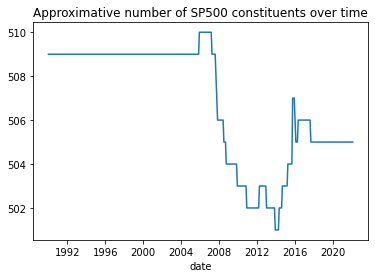

In [12]:
nb_spx_constituents=np.array([len(dico[date]) for date in date_sequence])
plt.plot(np.array(date_sequence, dtype='datetime64[M]'), nb_spx_constituents)
plt.title("Approximative number of SP500 constituents over time")
plt.xlabel("date")

In [13]:
print("average number of sp500 constituents:", round(nb_spx_constituents.mean(),2), "\nstd of sp500 constituents number:", round(nb_spx_constituents.std(),2))

average number of sp500 constituents: 506.84 
std of sp500 constituents number: 2.68


In [14]:
L=[]
for month, tickers in dico.items():
  for ticker in tickers:
    L.append((month, ticker))

df=pd.DataFrame(L, columns=["month", "ticker"])
df.sort_values(by="month", inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop_duplicates(inplace=True)

In [15]:
data["month"] = data.date.apply(lambda x: x[:-2]+'01')

In [16]:
sp = data.merge(df, how="inner", left_on=["month", "ticker"], right_on=["month", "ticker"])
sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017141 entries, 0 to 3017140
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   date       object 
 1   adj_close  float64
 2   ticker     object 
 3   month      object 
dtypes: float64(1), object(3)
memory usage: 115.1+ MB


Around 1 million data is lost since we only take prices of stocks in the period they belonged to SP500 

In [17]:
sp.dropna(inplace=True)

In [18]:
sp.sort_values(by=["ticker", "date"], inplace=True)

# Building the study periods

A study period (defined in [1] and [2]) is made of a pair of training period and trading period. A study period is equal to 1000 days and is composed of a training period, which is made of the first 750 days and a trading period, which is made of the last 250 days. The study periods are constructed iteratively such that the next study period is the forward translation of the current one by 250 days (so that the trading periods (the ends of the study periods) of two consecutive study periods do not overlap/intersect) 


From january 1990 to end of 2015 (resp 2019), there are roughly (26 * 250=6500 days) (resp. 30 * 250=7500 days). So by translating forward blocks of 1000 days (I.e study periods) from the beginning of 1990 to the end of 2015 (resp 2019), we get a number $x$ of study periods given by:
$$
1000+(x-1) * 250 = 6500 \; \text{(resp $1000+(x-1) * 250 = 7500$)}
$$

That is $x=23$ (resp $x=27$) study periods.

As in [1], let $n_i$ denote the number of S&P500 constituents at the very last day of the training period in study period $i$, so $n_i$ should be very close to 500 as one can see on the above plot of S&P500 number of constituents variation over time. But when merging the data, as explained previously, some data is lost, that is why $n_i$ is lower than 500.
For the training set, we consider all $n_i$ stocks with the history
they have available. Some stocks exhibit a full 750 day training history, some only a subset of this time frame, for example, when
they are listed at a later stage. The trading set is also composed of
all $n_i$ stocks. If a constituent exhibits no price data after a certain
day within the trading period, it is considered for trading up until
that day

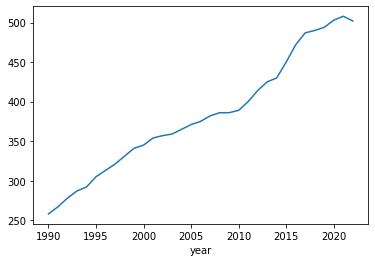

In [19]:
# Illustration of the number of S&P500 constituents over time after merging the data
sp["year"]=sp.month.apply(lambda x: x[:4])
sp.groupby(by="year").ticker.nunique().plot()

In [20]:
start_date_study_periods="1990-01-01"
end_date_study_periods="2015-12-31"
lstp=1000 # number of days in a study period
ltnp=750  # number of days in a training period
ltrp=lstp-ltnp # number of days in a trading period
if ltrp <= 0: raise ValueError ("The study period length should be greater than both the training and trading period lengths")

# reordering the dates
dates=sp.loc[(start_date_study_periods<=sp.date) & (sp.date<=end_date_study_periods), :].sort_values(by="date").date.unique() 

# training and trading dates for each period
number_study_periods=((len(dates)-lstp)//ltrp) + 1
study_period0 = {i+1: dates[ltrp*i:ltrp*i+lstp] for i in range(0, number_study_periods)}
study_period= {
               "training": {i: study_period0[i][:ltnp] for i in study_period0 if len(study_period0[i][:ltnp])==ltnp},
               "trading": {i: study_period0[i][ltnp:] for i in study_period0 if len(study_period0[i][ltnp:])==ltrp}
              }

# stocks that are present the last day of the trading periods 
last_days_train={i: max(study_period['training'][i]) for i in study_period['training']}
training_stocks0=sp.loc[sp.date.isin(last_days_train.values()), :][["date", "ticker"]] 

# last day for each period
ldt=pd.DataFrame(last_days_train.items()) 
ldt.columns=['period_number', "last_date_train"]

# associates each training period last day to the tickers available that day
tns=pd.DataFrame(training_stocks0.values)  
tns.columns=['last_date_train', 'ticker']

# last day for each training period
ldt_tns = ldt.merge(tns, how="inner", on='last_date_train')

# getting the dates associated to each study period
period_train_dates = pd.DataFrame([(i,t) for i in study_period['training'] for t in study_period['training'][i]])
period_train_dates.columns=['period_number', 'date']

# At last getting the stocks for training
train = period_train_dates.merge(ldt_tns, how='inner', on="period_number")[["date", "ticker"]]
train.drop_duplicates(inplace=True)
train = pd.merge(sp, train, how='inner', left_on=["date", "ticker"], right_on=["date", "ticker"])
train.sort_values(by=["date", "ticker"], inplace=True)
train=train[["date", "ticker", "adj_close"]]

# same pipeline for the trading period
first_days_trading={i: min(study_period['trading']) for i in study_period["trading"]}
fdt_trs = ldt_tns[["period_number","ticker"]]
period_trade_dates = pd.DataFrame([(i,t) for i in study_period['trading'] for t in study_period['trading'][i]])
period_trade_dates.columns=['period_number', 'date']

trade = period_trade_dates.merge(fdt_trs, how='inner', on="period_number")[["date", "ticker"]]
trade.drop_duplicates(inplace=True)
trade = pd.merge(sp, trade, how='inner', left_on=["date", "ticker"], right_on=["date", "ticker"])
trade=trade[["date", "ticker", "adj_close"]]
trade.sort_values(by=["date", "ticker"], inplace=True)

In [21]:
train["sub_period"]="training"
trade["sub_period"]="trading"

# Building the features

We do not normalise returns as in [1], the reason is that returns $R_t^{m}$ (in $m$ periods) are by definition:
$$
R_t^{m} =\frac{P_t}{P_{t-m}} -1
$$ already normalised and vary between -1 and 1 in general, except in case of some rare situations. 

In [22]:
train=compute_return(data=train, m=1, period=study_period, price_name="adj_close", ticker_name='ticker', date_name="date", sub_period_name="sub_period")
trade=compute_return(data=trade, m=1, period=study_period, price_name="adj_close", ticker_name='ticker', date_name="date", sub_period_name="sub_period")


Computing returns for training periods


100%|██████████| 467/467 [02:02<00:00,  3.83it/s]



Computing returns for trading periods


100%|██████████| 467/467 [01:47<00:00,  4.36it/s]


The authors proposed to normalize the returns as follows:
$$
\tilde{R}_t^m = \frac{R_t^m - \mu_{train}^m}{\sigma_{train}^m}
$$ 
where $\mu_{train}^m$ and $\sigma_{train}^m$ are respectively the mean and standard deviation obtained from the training set

In [23]:
train, mean_train, std_train=normalize_return(data=train, period=study_period, kind="in_period", return_name="return", date_name="date", sub_period_name="sub_period")

Normalizing the returns for training periods


100%|██████████| 23/23 [00:18<00:00,  1.28it/s]


In [24]:
trade=normalize_return(data=trade, mean_train=mean_train, std_train=std_train, period=study_period, kind="in_period", \
                       return_name="return", date_name="date", sub_period_name="sub_period")

Normalizing the returns for trading periods


100%|██████████| 23/23 [00:05<00:00,  4.56it/s]


In [25]:
print(train.head(1))
print(trade.head(1))

            date ticker  adj_close sub_period    return  raw_return
3753  1990-01-03     AA  13.573615   training  0.326478    0.014877
            date ticker  adj_close sub_period    return  raw_return
4001  1992-12-18     AA  14.180069    trading  0.265228    0.012281


# Building the target

In [26]:
train=compute_target(data=train, period=study_period, return_name="return", ticker_name='ticker', date_name="date", sub_period_name="sub_period")
trade=compute_target(data=trade, period=study_period, return_name="return", ticker_name='ticker', date_name="date", sub_period_name="sub_period")


Computing targets for training periods


100%|██████████| 467/467 [03:19<00:00,  2.34it/s]



Computing targets for trading periods


100%|██████████| 467/467 [02:58<00:00,  2.61it/s]


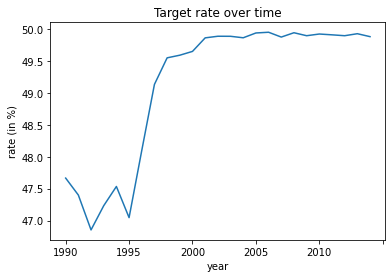

In [27]:
target_rate=train[["date", "target"]]
target_rate['year']=target_rate.date.apply(lambda x: x[:4])
(100*target_rate.groupby(by="year").target.sum()/target_rate.groupby(by="year").size()).plot()
plt.title("Target rate over time")
plt.ylabel("rate (in %)")
del target_rate

target rate over time should be stable around 50% by definition of the target, but one can see that between 1990 and 2000, it is below 50%, the reason is some returns are equal to the cross sectional median

In [28]:
period_train_dates["sub_period"]="training"
period_trade_dates["sub_period"]="trading"
period_dates=pd.concat([period_train_dates, period_trade_dates], axis=0)

study_data=pd.concat([train, trade], axis=0).reset_index(drop=True)
study_data=study_data.merge(period_dates, how='inner', on=['sub_period','date'])

# del train; del trade
del sp; del data

In [29]:
# Building the input sequences
inpseql=240 # length of the input sequences

input_sequences=build_input_sequences(data=study_data, inpseql=inpseql, period_name="period_number", ticker_name='ticker', \
                           return_name='return', target_name='target', date_name="date", sub_period_name="sub_period")
del study_data

Period 1 over 23


100%|██████████| 278/278 [00:32<00:00,  8.47it/s]


Period 2 over 23


100%|██████████| 285/285 [00:34<00:00,  8.35it/s]


Period 3 over 23


100%|██████████| 292/292 [00:35<00:00,  8.17it/s]


Period 4 over 23


100%|██████████| 301/301 [00:37<00:00,  8.09it/s]


Period 5 over 23


100%|██████████| 311/311 [00:39<00:00,  7.93it/s]


Period 6 over 23


100%|██████████| 321/321 [00:41<00:00,  7.79it/s]


Period 7 over 23


100%|██████████| 331/331 [00:43<00:00,  7.64it/s]


Period 8 over 23


100%|██████████| 340/340 [00:45<00:00,  7.50it/s]


Period 9 over 23


100%|██████████| 344/344 [00:46<00:00,  7.39it/s]


Period 10 over 23


100%|██████████| 356/356 [00:48<00:00,  7.27it/s]


Period 11 over 23


100%|██████████| 358/358 [00:49<00:00,  7.21it/s]


Period 12 over 23


100%|██████████| 358/358 [00:50<00:00,  7.09it/s]


Period 13 over 23


100%|██████████| 365/365 [00:51<00:00,  7.04it/s]


Period 14 over 23


100%|██████████| 369/369 [00:52<00:00,  7.00it/s]


Period 15 over 23


100%|██████████| 374/374 [00:53<00:00,  6.96it/s]


Period 16 over 23


100%|██████████| 379/379 [00:54<00:00,  6.93it/s]


Period 17 over 23


100%|██████████| 387/387 [00:56<00:00,  6.89it/s]


Period 18 over 23


100%|██████████| 388/388 [00:56<00:00,  6.89it/s]


Period 19 over 23


100%|██████████| 393/393 [00:57<00:00,  6.81it/s]


Period 20 over 23


100%|██████████| 400/400 [00:58<00:00,  6.78it/s]


Period 21 over 23


100%|██████████| 419/419 [01:02<00:00,  6.72it/s]


Period 22 over 23


100%|██████████| 432/432 [01:05<00:00,  6.64it/s]


Period 23 over 23


100%|██████████| 443/443 [01:07<00:00,  6.54it/s]


In [33]:
input_sequences.head()

,sub_period,period_number,date,ticker,X,y
0,trading,1,1992-12-18,AA,"[0.015804153314024433, -0.5563341111856593, -0...",0
1,trading,1,1992-12-18,AAPL,"[0.5853570364491298, 0.7368873165210751, -0.03...",1
2,trading,1,1992-12-18,ABT,"[-0.5777897782341332, -0.2159012760444677, 0.1...",0
3,trading,1,1992-12-18,ADBE,"[0.16853852693132582, -1.1231886045131976, -0....",1
4,trading,1,1992-12-18,ADI,"[-0.7216727851296252, 0.3154293966315053, -0.3...",1


In [30]:
## This part is an attempt to get the sectors of the firm mading up the S&P500

# from bs4 import BeautifulSoup
# import requests

# url = "http://www.google.com/finance?&q=IBM"
# # response = requests.get(url)
# response.content

# ! pip install urllib3

# import urllib3
# http = urllib3.PoolManager()
# url = 'https://finance.yahoo.com/quote/AAPL/profile?p=AAPL'
# response = http.request('GET', url)
# soup = BeautifulSoup(response.data)

# ############
# import urllib3
# from lxml.html import parse

# def GFinSectorIndustry(name):
#   tree = parse(urlopen('http://www.google.com/finance?&q='+name))
#   return tree.xpath("//a[@id='sector']")[0].text, tree.xpath("//a[@id='sector']")[0].getnext().tex

# text=str(soup)
# text

# Modelling

In [34]:
nb_validation=20000
train_data=input_sequences.loc[input_sequences.sub_period=="training",:]
trade_data=input_sequences.loc[input_sequences.sub_period=="trading",:]

In [35]:
# 
metrics={"dnn":dict(), "lgb":dict(), "xgb":dict(), "log":dict(), "rf":dict(), "lstm":dict()}
portfolio_perf={"dnn":dict(), "lgb":dict(), "xgb":dict(), "log":dict(), "rf":dict(), "lstm":dict()}
ks=[10,50,100]
for modl in metrics:
  metrics[modl]={"accuracy": dict(), "precision": dict(), "recall": dict(), "f1":dict()}
  for k in ks:
    metrics[modl][k]={"accuracy": dict(), "precision": dict(), "recall": dict(), 'f1':dict()}
    portfolio_perf[modl][k]={"mean_return": dict(), "annualized_mean_return": dict(),\
                        "sharpe_ratio": dict(), "annualized_sharpe_ratio": dict()}


for period in study_period['training']:
  print(f"\nTraining from {min(study_period['training'][period])} to {max(study_period['training'][period])}")

  # building the data 
  xtrain=np.stack(train_data.loc[train_data.period_number==period,].X, axis=0)
  ytrain=train_data.loc[train_data.period_number==period,].y
  xtrain,ytrain=xtrain[:-nb_validation],ytrain[:-nb_validation]
  xval,yval=xtrain[-nb_validation:],ytrain[-nb_validation:]
  xtrade=np.stack(trade_data.loc[trade_data.period_number==period, ].X, axis=0)
  ytrade=trade_data.loc[trade_data.period_number==period,].y

  # instantiating the models and training them

  ## dnn
  print("\nDEEP NEURAL NET")
  dnn = keras.models.Sequential([
          keras.layers.InputLayer(input_shape=(inpseql,)),
          keras.layers.Dense(31, activation="elu"),
          keras.layers.Dense(10, activation="elu"),
          keras.layers.Dense(5, activation="elu"),
          keras.layers.Dense(1, activation="sigmoid")
          ])
  precision=tf.keras.metrics.Precision()
  recall=tf.keras.metrics.Recall()
  dnn.compile(tf.optimizers.RMSprop(0.001), loss='binary_crossentropy', metrics=["accuracy", precision, recall])
  dnn.fit(xtrain, ytrain, batch_size=64, epochs=10, validation_data=(xval,yval))

  # ## xgboost
  # Reproducibility
  SEED = 120
  print("\nXGBOOST")
  xgb = XGBClassifier(max_depth = 4, n_estimators = 50, learning_rate = 0.05, n_jobs=10, tree_method='approx',\
                      objective='binary:logistic',eval_metric=['auc', 'logloss'], importance_type='total_gain', verbosity=1,
                      random_state=SEED)
  xgb.fit(xtrain, ytrain, eval_set=[(xval,yval)], early_stopping_rounds = 100)

  ## lightGBM
  print("\nLIGHTGBM")
  lgb = lbgm.LGBMClassifier(max_depth = 4, n_estimators = 100, learning_rate = 0.05, n_jobs=10, boosting_type ='gbdt',\
                      objective='binary',metrics=['auc', 'binary_logloss'], importance_type='gain', verbosity=1, random_state=SEED)
  lgb.fit(xtrain, ytrain, eval_set=[(xval,yval)], early_stopping_rounds = 100)

  ## log
  print("\nLOGISTIC REG")
  print("-------------->")
  log = LogisticRegression()
  log.fit(xtrain, ytrain)

  ## rf
  print("\nRF")
  print("-------------->")
  rf = XGBRFClassifier(n_estimators = 50, max_depth=4, learning_rate = 0.05, objective='binary:logistic',\
                       eval_metric=['auc', 'logloss'], random_state = SEED)
  rf.fit(xtrain, ytrain, eval_set=[(xval,yval)], early_stopping_rounds = 100)

  ## lstm
  print("\nLSTM")
  print("-------------->")
  # Data Loader Parameters
  BATCH_SIZE = 64
  TIMESTEP = 240
  NB_FEATURES = 1
  BUFFER_SIZE = 128
  # LSTM Parameters
  EVALUATION_INTERVAL =50
  EPOCHS = 20
  PATIENCE = 10
  tf.random.set_seed(SEED)
  lstm_train_data = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
  lstm_train_data = lstm_train_data.batch(BATCH_SIZE).repeat()

  lstm_val_data = tf.data.Dataset.from_tensor_slices((xval, yval))
  lstm_val_data = lstm_val_data.batch(BATCH_SIZE).repeat()

  lstm = tf.keras.models.Sequential()
  lstm.add(tf.keras.layers.LSTM(50, return_sequences=False, dropout=0.1,input_shape=[TIMESTEP,NB_FEATURES]))
  lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  precision=tf.keras.metrics.Precision()
  recall=tf.keras.metrics.Recall()
  lstm.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.000005), \
               loss='binary_crossentropy',  metrics=["accuracy", precision, recall])

  early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
  lstm.fit(lstm_train_data,
            epochs=EPOCHS,
            steps_per_epoch=EVALUATION_INTERVAL,
            validation_data=lstm_val_data,
            validation_steps=EVALUATION_INTERVAL,
            callbacks=[early_stopping],
            shuffle = False,
            verbose = 0)


  models={"lgb":lgb, "dnn":dnn, "xgb":xgb, "log":log, "lstm":lstm, "rf":rf}

  # computing some global metrics
  for modl in models:
    print(f'\nGlobal metrics for {modl.upper()}')
    if modl not in ['lstm', "dnn"]:
      results=compute_metrics(models[modl], xtrade, ytrade)
      if results is not None:
        metrics[modl]["accuracy"][period]=results[0]
        metrics[modl]["precision"][period]=results[1]
        metrics[modl]["recall"][period]=results[2]
        try:
          metrics[modl]["f1"][period]=2*results[2]*results[1]/(results[2]+results[1])
        except: metrics[modl]["f1"][period]=0
    else:
      results=models[modl].evaluate(xtrade, ytrade)
      metrics[modl]["accuracy"][period]=results[1]
      metrics[modl]["precision"][period]=results[2]
      metrics[modl]["recall"][period]=results[3]
      try:
        metrics[modl]["f1"][period]=2*results[2]*results[3]/(results[2]+results[3])
      except: metrics[modl]["f1"][period]=0
  



  # portfolio performance
  for modl in models: 
    print(f"\n{modl.upper()} performance computation\n")
    model=models[modl]

    period_trade_data=trade_data.loc[trade_data.period_number==period,]
    period_trade_days=trade_data.loc[trade_data.period_number==period,].date.sort_values().unique()
    period_data_return=trade.loc[trade.date.isin(period_trade_days), ["date", "ticker", "raw_return", "target"]]
    xtrade=np.stack(period_trade_data.X,axis=0)
    stocks=period_trade_data.ticker
    period_dates=period_trade_data.date

    if modl=="dnn" or modl=="lstm":
      probas=model.predict(xtrade).flatten()
    else:
      probas=model.predict_proba(xtrade)[:,1]
    d=pd.DataFrame({"ticker":stocks, "date":period_dates, "proba":probas})
    d=d.merge(period_data_return, on=["ticker", "date"]).sort_values(by=["date", "proba"])
    
    for k in ks:
      returns=[]
      top_flop_precision=[]
      top_flop_recall=[]
      top_flop_accuracy=[]
      top_flop_f1=[]
      for pos, day in tqdm(enumerate(period_trade_days[:-1]), total=len(period_trade_days[:-1])):
        stocks=list(d.ticker)
        top_stocks=d.loc[d.date==day,].ticker.iloc[:k]
        flop_stocks=d.loc[d.date==day,].ticker.iloc[-k:]
        next_day = period_trade_days[pos+1]
        # daily returns
        top_return=d.loc[(d.ticker.isin(top_stocks))&(d.date==next_day), "raw_return"].reset_index(drop=True).T.to_numpy()
        flop_return=d.loc[(d.ticker.isin(flop_stocks))&(d.date==next_day), "raw_return"].reset_index(drop=True).T.to_numpy()
        daily_return=np.mean(top_return)
        returns.append(daily_return)
        # top flop metrics
        top_target=d.loc[(d.ticker.isin(top_stocks))&(d.date==next_day), "target"].reset_index(drop=True).T.to_numpy()
        flop_target=d.loc[(d.ticker.isin(flop_stocks))&(d.date==next_day), "target"].reset_index(drop=True).T.to_numpy()
        daily_target=np.concatenate([top_target, flop_target], axis=0)
        prediction=np.array([1]*len(top_target)+[0]*len(flop_target))
        TP = np.where((prediction==1)&(daily_target==1))[0]
        FP = np.where((prediction==1)&(daily_target==0))[0]
        try:
          prec=len(TP)/(len(TP)+len(FP))
          rec=len(TP)/len(np.where(daily_target==1)[0])
          acc=np.mean(daily_target==prediction)
          top_flop_precision.append(prec)
          top_flop_recall.append(rec)
          top_flop_accuracy.append(acc)
          top_flop_f1.append(2*prec*rec/(prec+rec))
        except:pass
      
      metrics[modl][k]["precision"][period]=np.mean(top_flop_precision)
      metrics[modl][k]["recall"][period]=np.mean(top_flop_recall)
      metrics[modl][k]["f1"][period]=np.mean(top_flop_f1)
      metrics[modl][k]["accuracy"][period]=np.mean(top_flop_accuracy)
          
      mean_return = np.mean(returns)
      annualized_mean_return=250*mean_return
      std_return = np.std(returns)
      annualized_std = np.sqrt(250)*std_return
      sharpe_ratio=mean_return/std_return
      annualized_sharpe_ratio = annualized_mean_return/annualized_std
      portfolio_perf[modl][k]["mean_return"][period] = mean_return
      portfolio_perf[modl][k]["annualized_mean_return"][period] = annualized_mean_return
      portfolio_perf[modl][k]["sharpe_ratio"][period] = sharpe_ratio
      portfolio_perf[modl][k]["annualized_sharpe_ratio"][period] = annualized_sharpe_ratio
  
  clear_output(wait=True)


Training from 2011-10-25 to 2014-10-17

DEEP NEURAL NET
Epoch 1/10
2821/2821 [==============================] - 8s 2ms/step - loss: 0.6932 - accuracy: 0.5037 - precision: 0.5035 - recall: 0.5132 - val_loss: 0.6925 - val_accuracy: 0.5059 - val_precision: 0.5546 - val_recall: 0.0383
Epoch 2/10
2821/2821 [==============================] - 6s 2ms/step - loss: 0.6926 - accuracy: 0.5114 - precision: 0.5117 - recall: 0.4909 - val_loss: 0.6914 - val_accuracy: 0.5296 - val_precision: 0.5318 - val_recall: 0.4629
Epoch 3/10
2821/2821 [==============================] - 6s 2ms/step - loss: 0.6923 - accuracy: 0.5150 - precision: 0.5155 - recall: 0.4931 - val_loss: 0.6912 - val_accuracy: 0.5196 - val_precision: 0.5111 - val_recall: 0.8059
Epoch 4/10
2821/2821 [==============================] - 6s 2ms/step - loss: 0.6928 - accuracy: 0.5182 - precision: 0.5193 - recall: 0.4863 - val_loss: 0.6900 - val_accuracy: 0.5275 - val_precision: 0.5304 - val_recall: 0.4455
Epoch 5/10
2821/2821 [=================

100%|██████████| 246/246 [00:17<00:00, 13.87it/s]



DNN performance computation



100%|██████████| 246/246 [00:17<00:00, 14.00it/s]



XGB performance computation



100%|██████████| 246/246 [00:17<00:00, 13.90it/s]



LOG performance computation



100%|██████████| 246/246 [00:17<00:00, 14.02it/s]



LSTM performance computation



100%|██████████| 246/246 [00:17<00:00, 13.96it/s]



RF performance computation



100%|██████████| 246/246 [00:17<00:00, 14.00it/s]


Text(0.5, 0.98, 'Model metrics for k = 10 portfolio')

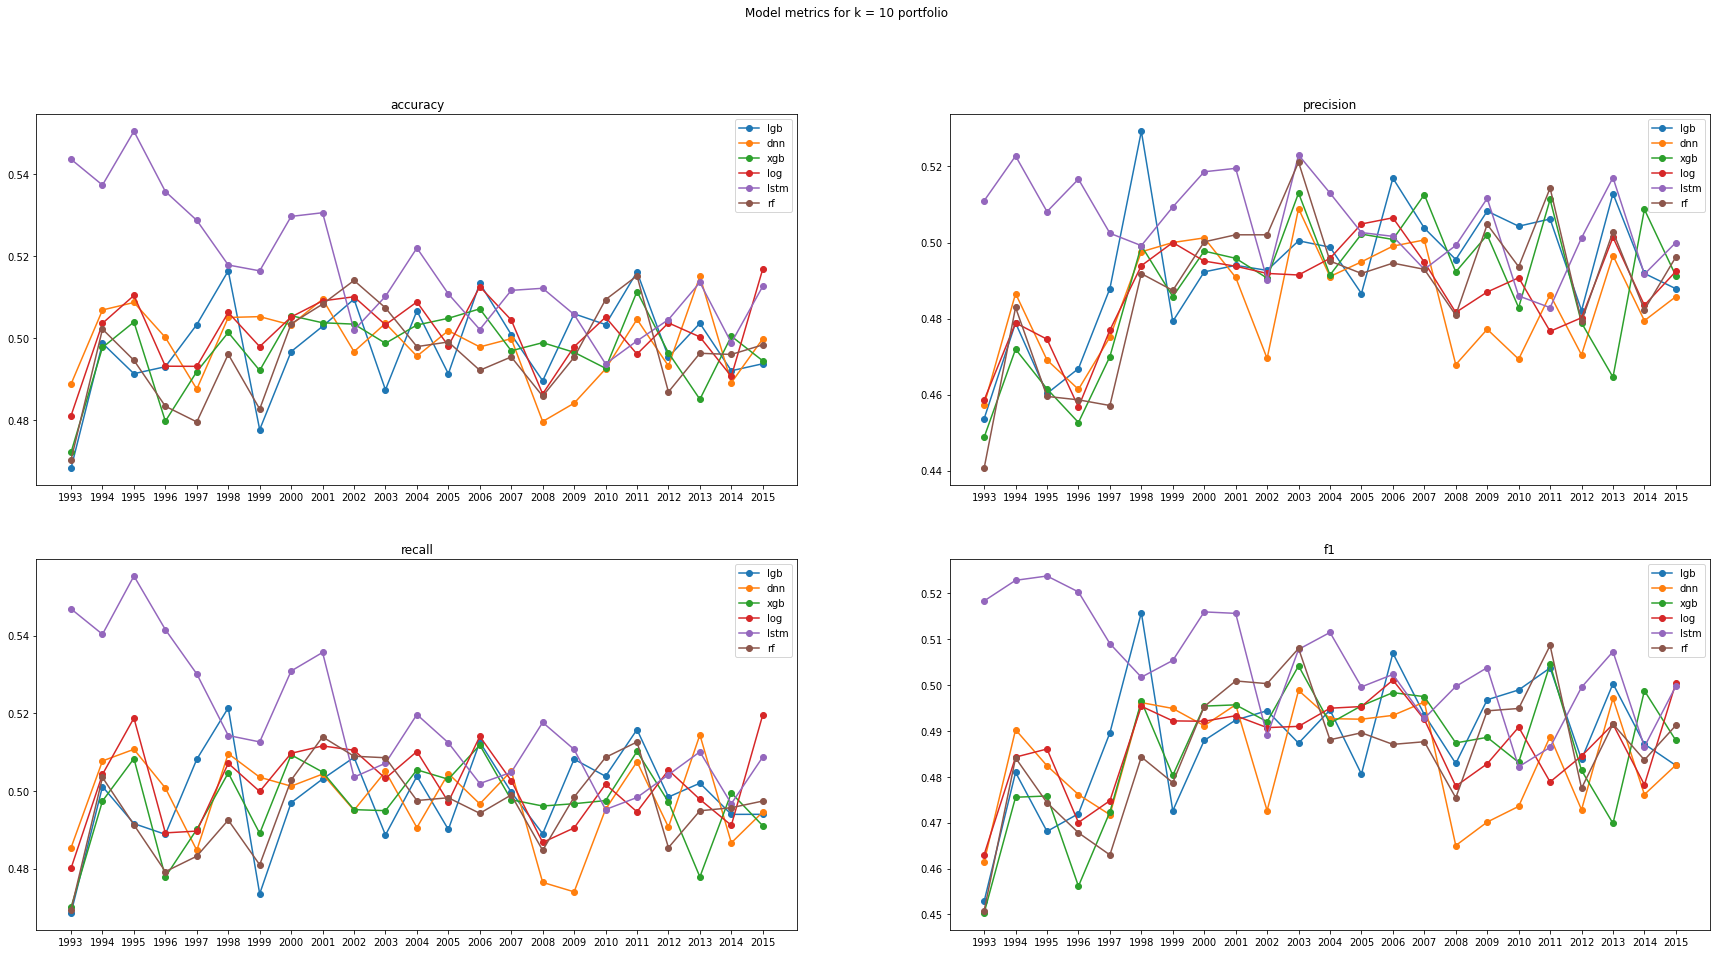

In [55]:
fig, ax= plt.subplots(2,2, figsize=(30,15))
k=10
for model in models:
  # print(f'{model}')
  period_number=list(metrics[model][k]["accuracy"].keys())
  periods=list(map(lambda x: max(study_period["trading"][x])[:4], period_number))
  ax[0,0].plot(periods, list(metrics[model][k]["accuracy"].values()), 'o-', label=model)
  ax[0,0].set_title("accuracy")
  ax[0,0].legend()
  ax[0,1].plot(periods, list(metrics[model][k]["precision"].values()), 'o-', label=model)
  ax[0,1].set_title("precision")
  ax[0,1].legend()
  ax[1,0].plot(periods, list(metrics[model][k]["recall"].values()), 'o-', label=model)
  ax[1,0].set_title("recall")
  ax[1,0].legend()
  ax[1,1].plot(periods, list(metrics[model][k]["f1"].values()), 'o-', label=model)
  ax[1,1].set_title("f1")
  ax[1,1].legend()
plt.suptitle(f"Model metrics for k = {k} portfolio")

Text(0.5, 0.98, 'Global model metrics')

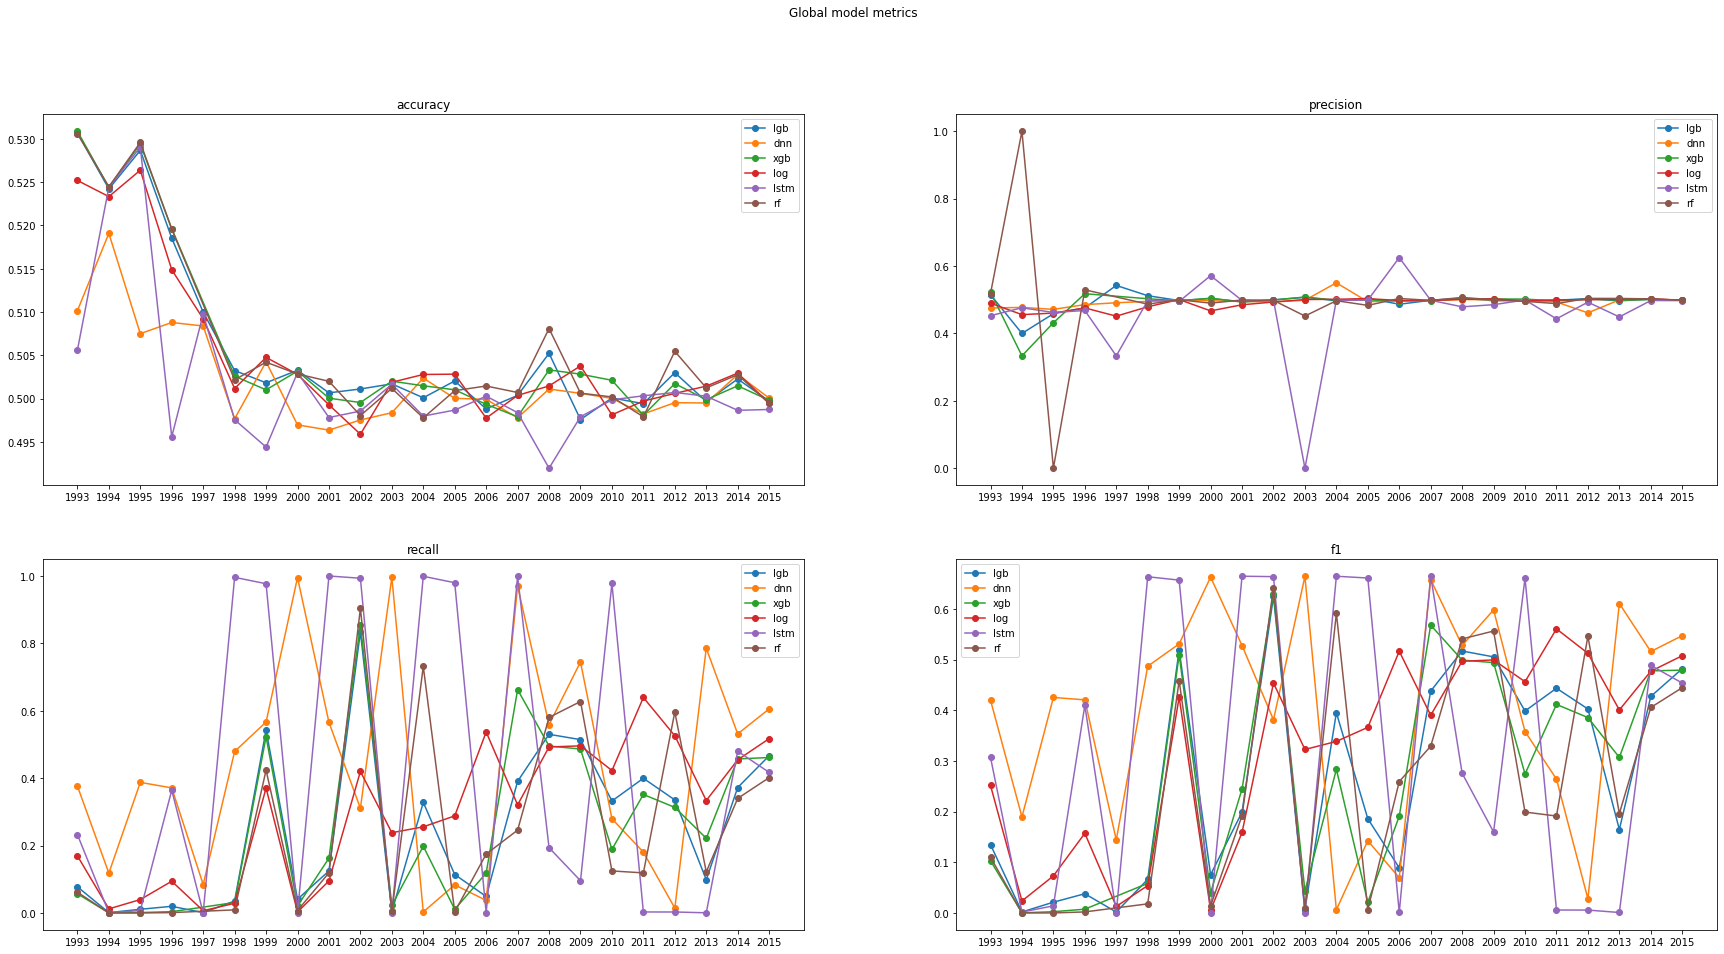

In [57]:
fig, ax= plt.subplots(2,2, figsize=(30,15))
for model in models:
  # print(f'{model}')
  period_number=list(metrics[model]["accuracy"].keys())
  periods=list(map(lambda x: max(study_period["trading"][x])[:4], period_number))
  ax[0,0].plot(periods, list(metrics[model]["accuracy"].values()), 'o-', label=model)
  ax[0,0].set_title("accuracy")
  ax[0,0].legend()
  ax[0,1].plot(periods, list(metrics[model]["precision"].values()), 'o-', label=model)
  ax[0,1].set_title("precision")
  ax[0,1].legend()
  ax[1,0].plot(periods, list(metrics[model]["recall"].values()), 'o-', label=model)
  ax[1,0].set_title("recall")
  ax[1,0].legend()
  ax[1,1].plot(periods, list(metrics[model]["f1"].values()), 'o-', label=model)
  ax[1,1].set_title("f1")
  ax[1,1].legend()
plt.suptitle("Global model metrics")

Text(0.5, 0.98, 'Performance of k = 10 portfolio')

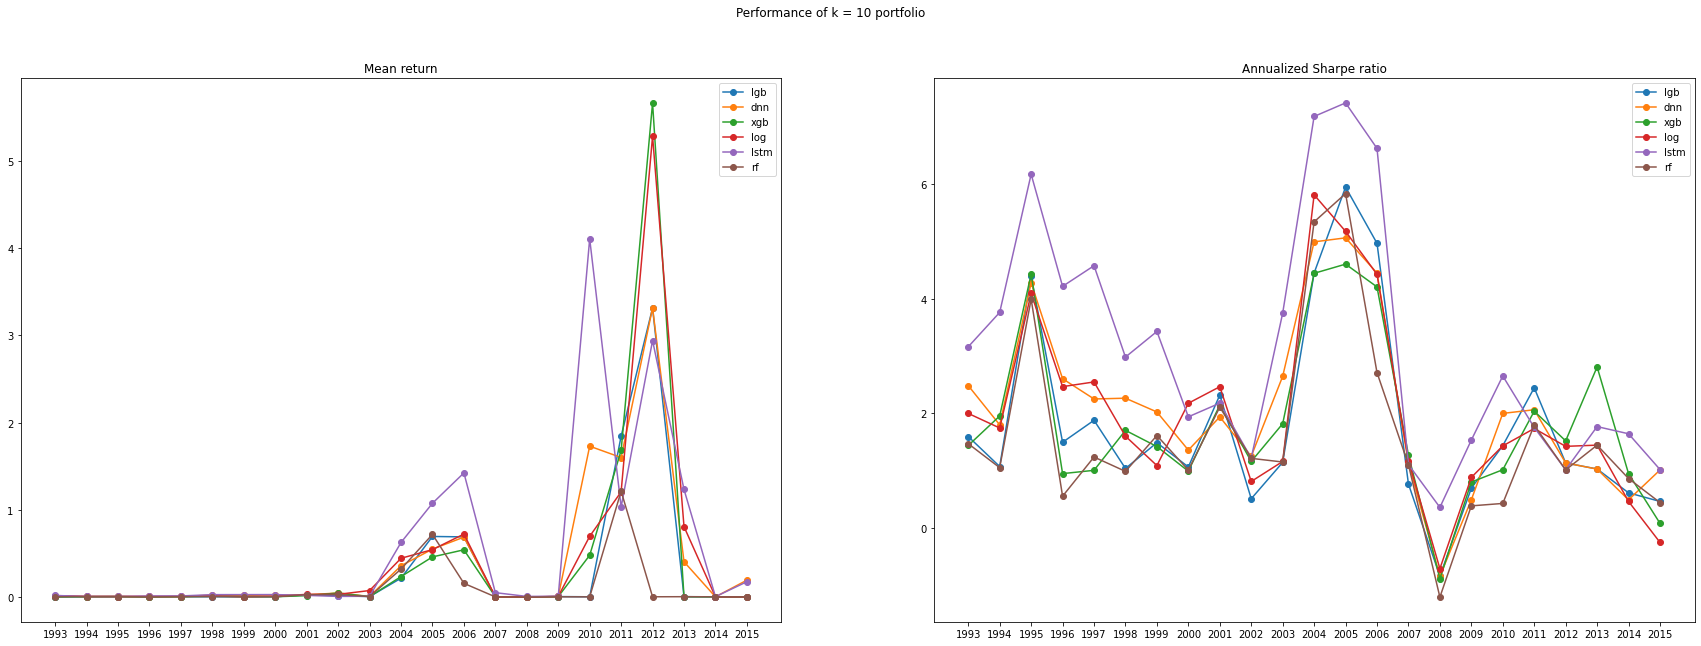

In [58]:
fig, ax= plt.subplots(1,2, figsize=(30,10))
k=10
for model in models:
  # print(f'{model}')
  period_number=list(portfolio_perf[model][k]["mean_return"].keys())
  periods=list(map(lambda x: max(study_period["trading"][x])[:4], period_number))
  ax[0].plot(periods, list(portfolio_perf[model][k]["mean_return"].values()), 'o-', label=model)
  ax[0].set_title("Mean return")
  ax[0].legend()
  ax[1].plot(periods, list(portfolio_perf[model][50]["annualized_sharpe_ratio"].values()), 'o-', label=model)
  ax[1].set_title("Annualized Sharpe ratio")
  ax[1].legend()
  # ax[0].plot(periods, list(metrics[model]['top_flop']["recall"].values()), 'o-', label=model)
  # ax[1,0].set_title("recall")
  # ax[1,0].legend()
  # ax[1,1].plot(periods, list(metrics[model]['top_flop']["f1"].values()), 'o-', label=model)
  # ax[1,1].set_title("f1")
  # ax[1,1].legend()
plt.suptitle(f"Performance of k = {k} portfolio")

(0.45, 0.6)

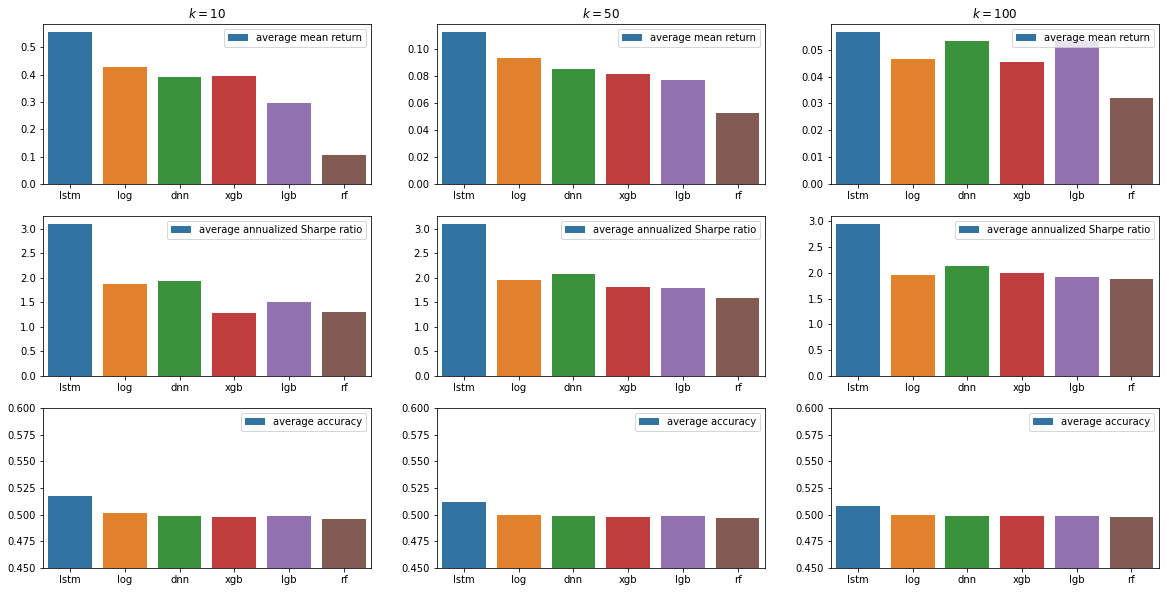

In [107]:
fig, ax= plt.subplots(3,3, figsize=(20,10))
k=10
model_list=['lstm',"log", 'dnn', "xgb", "lgb", "rf" ]
import seaborn as sb

sb.barplot(model_list, [np.mean(list(portfolio_perf[model][10]["mean_return"].values())) for model in model_list], ax=ax[0,0], label="average mean return")
ax[0,0].legend()
ax[0,0].set_title("$k=10$")
sb.barplot(model_list, [np.mean(list(portfolio_perf[model][50]["mean_return"].values())) for model in model_list], ax=ax[0,1], label="average mean return")
ax[0,1].legend()
ax[0,1].set_title("$k=50$")
sb.barplot(model_list, [np.mean(list(portfolio_perf[model][100]["mean_return"].values())) for model in model_list], ax=ax[0,2], label="average mean return")
ax[0,2].legend()
ax[0,2].set_title("$k=100$")

sb.barplot(model_list, [np.mean(list(portfolio_perf[model][10]["annualized_sharpe_ratio"].values())) for model in model_list], ax=ax[1,0], label="average annualized Sharpe ratio")
ax[1,0].legend()
sb.barplot(model_list, [np.mean(list(portfolio_perf[model][50]["annualized_sharpe_ratio"].values())) for model in model_list], ax=ax[1,1], label="average annualized Sharpe ratio")
ax[1,1].legend()
sb.barplot(model_list, [np.mean(list(portfolio_perf[model][100]["annualized_sharpe_ratio"].values())) for model in model_list], ax=ax[1,2], label="average annualized Sharpe ratio")
ax[1,2].legend()

sb.barplot(model_list, [np.mean(list(metrics[model][10]["accuracy"].values())) for model in model_list], ax=ax[2,0], label="average accuracy")
ax[2,0].legend()
ax[2,0].set_ylim(0.45,0.6)
sb.barplot(model_list, [np.mean(list(metrics[model][50]["accuracy"].values())) for model in model_list], ax=ax[2,1], label="average accuracy")
ax[2,1].legend()
ax[2,1].set_ylim(0.45,0.6)
sb.barplot(model_list, [np.mean(list(metrics[model][100]["accuracy"].values())) for model in model_list], ax=ax[2,2], label="average accuracy")
ax[2,2].legend()
ax[2,2].set_ylim(0.45,0.6)

### Probability that the performance of LSTM is pure luck

In [56]:
import numpy as np
import scipy.stats as ss

ss.norm.sf(0.52, loc=0.5, scale=np.sqrt(0.25/102000))

1.1310940835947718e-37

In [ ]:
#! rm -r ./ml-for-finance/data/concatenated_adj_close_data_sp500_stocks.csv  # removing the csv file from the data folder (done in case of pushing to github)

# References

[1] T. Fischer, C. Krauss (2017) : Deep learning with long short-term memory networks for financial market predictions, Ideas:886576210

[2] Krauss, C., Do, X. A., & Huck, N. (2017). Deep neural networks, gradient-boosted trees, random forests: Statistical arbitrage on the S&P 500. European Journal of Operational Research, 259(2), 689–702.